# Toy Dataset Experiments (Figure 7)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

from utils.datasets import generate_toy_data
from utils.helpers import get_threshold
from utils.protocols import algo2_end
from utils.scores import get_precision_recall_f1score, get_auc

In [2]:
easy_radius = 2.5
hard_radius = 2.1

big_contamination = 0.2
low_contamination = 0.05

dataset_params = {
    "a": (low_contamination, easy_radius),
    "b": (big_contamination, easy_radius),
    "c": (big_contamination, hard_radius),
}

img_format = 'pdf'
dpi = 512

## Three examplar datasets

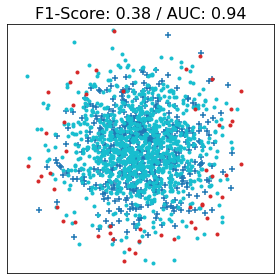

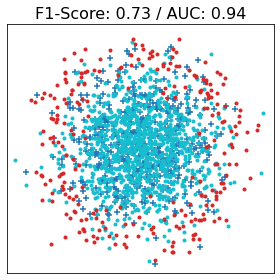

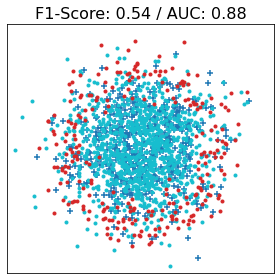

In [3]:
metrics = {}
legend = None
for dataset, (cont, radius) in dataset_params.items():
    # Compute the metrics
    x_train, x_test, y_test = generate_toy_data(cont, radius)
    clf = GaussianMixture(n_components=1, covariance_type='full')
    f1_score, auc, _, _ = algo2_end(x_train, x_test, y_test, clf)
    metrics[dataset] = (f1_score, auc)
    
    # Plot the datasets
    plt.figure(figsize=[4, 4])

    plt.axis('equal')
    plt.axis([-3.5, 3.5, -3.5, 3.5])

    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.scatter(*x_train.T, marker='+', color='tab:blue', label='train - normal')
    plt.scatter(*x_test[y_test == 0].T, marker='.', color='tab:cyan', label='test - normal')
    plt.scatter(*x_test[y_test == 1].T, marker='.', color='tab:red', label='test - anomaly')
    
    if legend is None:
        legend = plt.gca().get_legend_handles_labels()
        
    plt.title(f"F1-Score: {f1_score:.2f} / AUC: {auc:.2f}", fontsize=16)
    plt.tight_layout()
    str_radius = str(radius).replace(".", "_")
    str_cont = str(cont).replace(".", "_")
    plt.savefig(f"results/toy_dataset_radius_{str_radius}_contamination_{str_cont}.{img_format}",
                format=img_format, dpi=dpi)
    plt.show()

## Generalisation of the three examplar datasets

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


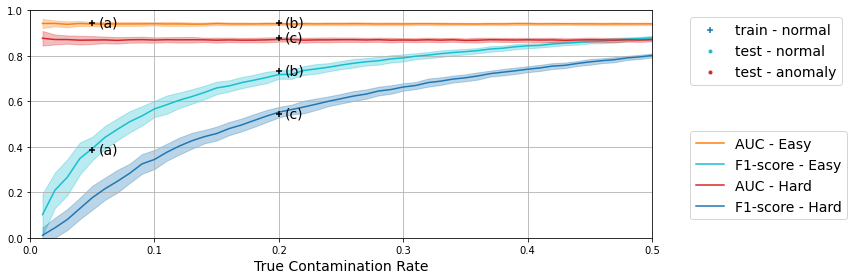

In [4]:
plt.figure(figsize=[12,4])
n_runs = 100
n_points = 50
contamination_rates = np.linspace(0.01, 0.5, n_points)
for easy in [True, False]:
    radius = easy_radius if easy else hard_radius
    f1_scores = np.zeros((n_points, n_runs))
    aucs = np.zeros((n_points, n_runs))

    for j in tqdm(range(n_runs)):
        for i, cont in enumerate(contamination_rates):
            x_train, x_test, y_test = generate_toy_data(cont, radius)
            clf = GaussianMixture(n_components=1, covariance_type='full')
            f1_score, auc, _, _ = algo2_end(x_train, x_test, y_test, clf)
            f1_scores[i, j] = f1_score
            aucs[i, j] = auc
    f1_mean = np.mean(f1_scores, axis=1)
    f1_std = np.std(f1_scores, axis=1, ddof=1)
    auc_mean = np.mean(aucs, axis=1)
    auc_std = np.std(aucs, axis=1, ddof=1)
    
    s_easy = "Easy" if easy else "Hard"
    color = "tab:orange" if easy else "tab:red"
    plt.plot(contamination_rates, auc_mean, label=f'AUC - {s_easy}', color=color)
    plt.fill_between(contamination_rates, auc_mean + auc_std, auc_mean - auc_std, alpha=0.3, color=color)
    
    color = "tab:cyan" if easy else "tab:blue"
    plt.plot(contamination_rates,  f1_mean, label=f'F1-score - {s_easy}', color=color)
    plt.fill_between(contamination_rates, f1_mean + f1_std, f1_mean - f1_std, alpha=0.3, color=color)

for dataset, metric_values in metrics.items():
    cont = dataset_params[dataset][0]
    for metric in metric_values:
        plt.scatter([cont], [metric], marker='+', color="black", zorder=3)
        plt.annotate(f'({dataset})', xy=(cont + 0.005, metric - 0.015), fontsize=14)

plt.ylim([0 ,1.0])
plt.xlim([0, 0.5])

plt.gca().add_artist(plt.legend(*legend, bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=14))
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=14)
plt.xlabel(f"True Contamination Rate", fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig(f"results/toy_example_easy_vs_hard_dataset.{img_format}", format=img_format, dpi=dpi)
plt.show()